In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Device: cuda


100%|██████████| 26.4M/26.4M [00:01<00:00, 17.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 272kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.06MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.1MB/s]



Training FashionMNIST DCGAN...


FashionMNIST training finished.


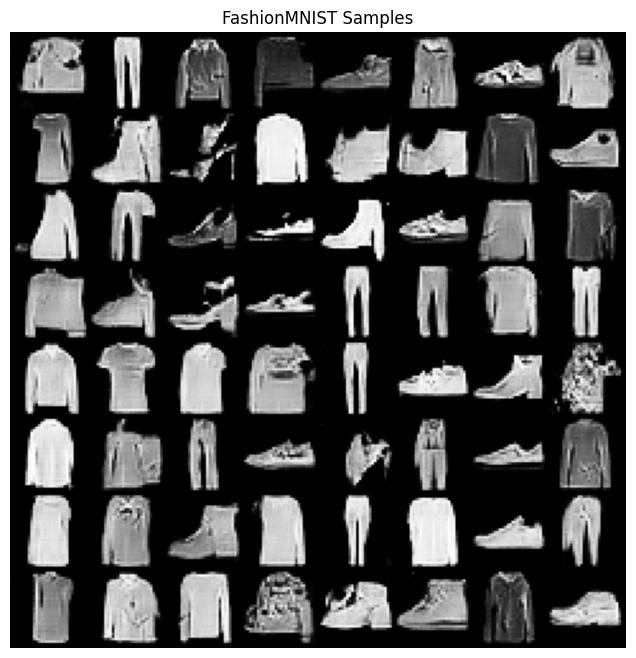


Computing FID (FashionMNIST)...


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 190MB/s]  


FID = 40.8291
Saved final checkpoint.


In [5]:
# single_file_fashion_dcgan_fid.py
# Kaggle-friendly single-script
# Requirements: torch, torchvision, scipy, numpy, matplotlib, tqdm

import os
import math
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models, utils

from scipy import linalg

# --------------------
# Device
# --------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# --------------------
# Global seeds (optional)
# --------------------
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# --------------------
# DCGAN MODELS (FashionMNIST)
# --------------------
class DCGANGenerator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, 7, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, z):
        return self.model(z)

class DCGANDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1)
        )
    def forward(self, x):
        return self.model(x)

# --------------------
# DCGAN TRAINING
# --------------------
def train_fashion_dcgan(
    dataloader,
    latent_dim=100,
    num_epochs=30,
    lr=2e-4,
    beta1=0.5,
    save_dir='fashion_checkpoints',
    device=DEVICE
):
    os.makedirs(save_dir, exist_ok=True)
    G = DCGANGenerator(latent_dim).to(device)
    D = DCGANDiscriminator().to(device)

    g_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
    d_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
    criterion = nn.BCEWithLogitsLoss()

    history = {'d_loss': [], 'g_loss': []}
    fixed_z = torch.randn(64, latent_dim, 1, 1, device=device)

    print("\nTraining FashionMNIST DCGAN...")
    for epoch in range(num_epochs):
        d_losses, g_losses = [], []
        pbar = tqdm(dataloader, desc=f"Fashion Epoch {epoch+1}/{num_epochs}", leave=False)

        for real_imgs, _ in pbar:
            real_imgs = real_imgs.to(device)
            bsize = real_imgs.size(0)

            real_labels = torch.ones(bsize, 1, device=device)
            fake_labels = torch.zeros(bsize, 1, device=device)

            # Train D
            d_optimizer.zero_grad()
            z = torch.randn(bsize, latent_dim, 1, 1, device=device)
            fake_imgs = G(z).detach()

            real_logits = D(real_imgs)
            fake_logits = D(fake_imgs)
            d_loss = criterion(real_logits, real_labels) + criterion(fake_logits, fake_labels)
            d_loss.backward()
            d_optimizer.step()

            # Train G
            g_optimizer.zero_grad()
            z = torch.randn(bsize, latent_dim, 1, 1, device=device)
            fake_imgs = G(z)
            fake_logits_for_g = D(fake_imgs)
            g_loss = criterion(fake_logits_for_g, real_labels)
            g_loss.backward()
            g_optimizer.step()

            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            pbar.set_postfix({"D": f"{d_loss.item():.4f}", "G": f"{g_loss.item():.4f}"})

        history['d_loss'].append(np.mean(d_losses))
        history['g_loss'].append(np.mean(g_losses))

        if (epoch + 1) % 10 == 0 or epoch == num_epochs - 1:
            torch.save({"G": G.state_dict(), "D": D.state_dict(), "history": history},
                       os.path.join(save_dir, f"fashion_epoch_{epoch+1}.pt"))

    print("FashionMNIST training finished.")
    return G, D, history, fixed_z

# --------------------
# Sampling utilities
# --------------------
def show_image_grid_from_tensor(img_tensor, nrow=8, title=None):
    grid = utils.make_grid((img_tensor + 1) / 2.0, nrow=nrow, padding=2)
    npimg = grid.cpu().numpy().transpose(1,2,0)
    plt.figure(figsize=(8,8))
    plt.imshow(npimg.squeeze(), cmap="gray")
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()

# --------------------
# FID UTILITIES
# --------------------
from torchvision.models import Inception_V3_Weights

class InceptionActivations(nn.Module):
    def __init__(self):
        super().__init__()
        weights = Inception_V3_Weights.IMAGENET1K_V1
        inc = models.inception_v3(weights=weights)
        inc.eval()
        self.inc = inc

    def forward(self, x):
        x = self.inc.Conv2d_1a_3x3(x)
        x = self.inc.Conv2d_2a_3x3(x)
        x = self.inc.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, 3, 2)
        x = self.inc.Conv2d_3b_1x1(x)
        x = self.inc.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, 3, 2)
        x = self.inc.Mixed_5b(x)
        x = self.inc.Mixed_5c(x)
        x = self.inc.Mixed_5d(x)
        x = self.inc.Mixed_6a(x)
        x = self.inc.Mixed_6b(x)
        x = self.inc.Mixed_6c(x)
        x = self.inc.Mixed_6d(x)
        x = self.inc.Mixed_6e(x)
        x = self.inc.Mixed_7a(x)
        x = self.inc.Mixed_7b(x)
        x = self.inc.Mixed_7c(x)
        x = self.inc.avgpool(x)
        x = torch.flatten(x, 1)
        return x

imagenet_mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(DEVICE)
imagenet_std  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(DEVICE)

def imagenet_normalize(t):
    t = (t + 1) / 2
    return (t - imagenet_mean) / imagenet_std

def get_acts_from_loader(loader, model, device):
    model = model.to(device).eval()
    acts = []
    with torch.no_grad():
        for imgs, _ in tqdm(loader, desc="Real activations", leave=False):
            imgs = imgs.to(device)
            acts.append(model(imgs).cpu().numpy())
    return np.concatenate(acts, axis=0)

def get_acts_generated(gen, n_imgs, batch, model, device, latent=100):
    model = model.to(device).eval()
    acts = []

    with torch.no_grad():
        done = 0
        while done < n_imgs:
            b = min(batch, n_imgs - done)
            z = torch.randn(b, latent, 1, 1, device=device)
            fake = gen(z)

            fake = F.interpolate(fake, size=(299,299), mode='bilinear', align_corners=False)
            fake = fake.repeat(1,3,1,1)  # grayscale → RGB
            fake = imagenet_normalize(fake)

            acts.append(model(fake).cpu().numpy())
            done += b

    return np.concatenate(acts, axis=0)

def frechet_distance(mu1, s1, mu2, s2, eps=1e-6):
    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(s1.dot(s2), disp=False)
    if not np.isfinite(covmean).all():
        covmean = linalg.sqrtm((s1+eps*np.eye(s1.shape[0])).dot(s2+eps*np.eye(s2.shape[0])))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return diff.dot(diff) + np.trace(s1) + np.trace(s2) - 2*np.trace(covmean)

def compute_fid(loader_real, gen, n=1000, batch=64, device=DEVICE):
    inc = InceptionActivations().to(device)
    acts_real = get_acts_from_loader(loader_real, inc, device)
    mu_r, sig_r = acts_real.mean(0), np.cov(acts_real, rowvar=False)

    acts_fake = get_acts_generated(gen, n, batch, inc, device)
    mu_f, sig_f = acts_fake.mean(0), np.cov(acts_fake, rowvar=False)

    return frechet_distance(mu_r, sig_r, mu_f, sig_f)

# --------------------
# DATA
# --------------------
BATCH = 128

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

fid_transform = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: t.repeat(3,1,1)),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

fashion_dataset = datasets.FashionMNIST("./data", train=True, download=True, transform=train_transform)
fashion_loader = DataLoader(fashion_dataset, batch_size=BATCH, shuffle=True, num_workers=2)

fid_dataset = datasets.FashionMNIST("./data", train=True, download=False, transform=fid_transform)
fid_loader = DataLoader(fid_dataset, batch_size=64, shuffle=False, num_workers=2)

# --------------------
# MAIN
# --------------------
if __name__ == "__main__":
    LATENT = 100
    EPOCHS = 30

    G, D, history, fixed_z = train_fashion_dcgan(
        fashion_loader,
        latent_dim=LATENT,
        num_epochs=EPOCHS,
        lr=2e-4,
        beta1=0.5,
        save_dir="fashion_checkpoints",
        device=DEVICE
    )

    # show samples
    with torch.no_grad():
        fake = G(fixed_z).cpu()
    show_image_grid_from_tensor(fake, title="FashionMNIST Samples")

    # compute FID
    print("\nComputing FID (FashionMNIST)...")
    fid_value = compute_fid(fid_loader, G, n=1000, batch=64, device=DEVICE)
    print(f"FID = {fid_value:.4f}")

    torch.save({"G": G.state_dict(), "D": D.state_dict()}, "fashion_gan_final.pt")
    print("Saved final checkpoint.")
    


In [6]:
# Save the generator model
torch.save(G.state_dict(), '/kaggle/working/generator.pth')

# Save the discriminator too
torch.save(D.state_dict(), '/kaggle/working/discriminator.pth')

print("✓ Models saved!")


✓ Models saved!
